#Access to Google :

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NewsClassification

Mounted at /content/drive
/content/drive/MyDrive/NewsClassification


#Gereken Kütüphaneleri import et

In [2]:
import sqlite3
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#The BERT Model We Will Use

In [5]:
#Bert Modeli
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

#Loading and Exploring the Dataset

In [4]:
database_file = 'News.db'
conn = sqlite3.connect(database_file)
query = "SELECT * FROM Haberler"
df = pd.read_sql(query, conn)
conn.close()

In [6]:
df

,Id,Baslik,Icerik,Kategori,Kaynak,Tarih
0,918,I﻿sıtılmamış bir oda vücudunuza nasıl etki eder?,Öldürücü soğuk deyince aklıma sakallarından bu...,bilim,BBC,2022-11-19 00:00:00
1,919,"L﻿aboratuvarda üretilen tavuk eti, ABD'de tüke...",Amerika’da laboratuvarda üretilmiş bir etin in...,bilim,BBC,2022-11-19 00:00:00
2,920,'Erkekler için tasarlanan f﻿utbol topları ve k...,"Spor üzerine çalışan bilim insanları, kadınlar...",bilim,BBC,2022-11-19 00:00:00
3,921,"İngiltere'ye düşen göktaşı, uzaydan gelen kaya...",Geçen yıl İngiltere’nin Cotswolds bölgesindeki...,bilim,BBC,2022-11-17 00:00:00
4,922,"1﻿1 yaşındaki Yusuf Şah, Mensa zeka testinde 1...",İ﻿ngiltere'nin Leeds kentinde yaşayan 11 yaşın...,bilim,BBC,2022-11-16 00:00:00
...,...,...,...,...,...,...
53456,80219,Batman’da 3 bin kişilik aşiret HDP’den AK Part...,Batman’da 3 bin kişilik aşiret HDP’den AK Part...,gündem,TurkiyeGazetesi,2019-03-10 20:19:00
53457,80220,Hikmet Karaman: 'Rakibimizi tebrik ediyoruz',Hikmet Karaman: 'Rakibimizi tebrik ediyoruz' 1...,spor,TurkiyeGazetesi,2019-03-10 22:31:00
53458,80221,Etiyopya devlet televizyonu duyurdu: Düşen uça...,Etiyopya devlet televizyonu duyurdu: Düşen uça...,dünya,TurkiyeGazetesi,2019-03-10 16:33:00
53459,80223,Numan Kurtulmuş Sancaktepe’de vatandaşlarla bu...,Numan Kurtulmuş Sancaktepe’de vatandaşlarla bu...,siyaset,TurkiyeGazetesi,2019-03-11 01:20:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53461 entries, 0 to 53460
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        53461 non-null  int64 
 1   Baslik    53461 non-null  object
 2   Icerik    53461 non-null  object
 3   Kategori  53461 non-null  object
 4   Kaynak    53461 non-null  object
 5   Tarih     53461 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.4+ MB


The data appears to have been successfully retrieved from News.db. As a result of running the code, the table contains a total of 53,461 records spread across 6 columns. The total data size in memory is approximately 2.4 MB. The data is ready for analysis.

In [8]:
df.Baslik[1]

"L\ufeffaboratuvarda üretilen tavuk eti, ABD'de tüketim onayı aldı"

#the pre-processing method that we will use for Title Column



In [9]:
#Pre-process
file_path = "stop.tr.turkish-lucene.txt"
with open(file_path, "r", encoding="utf-8") as file:
    stop_words = file.read().splitlines()
def clean(df):
    punctuation_no_space = re.compile(r"(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})|(‘)|(“)|(”)|(°)|(\')")
    punctuation_with_space = re.compile(r"(<br\s/><br\s/?)|(-)|(/)|(:)")
    html_tags = r'<.*?>'
    cleaned_lines = []
    for line in df:
        line_cleaned = punctuation_no_space.sub("", line.lower())
        line_cleaned = punctuation_with_space.sub(" ", line_cleaned)
        line_cleaned = re.sub(html_tags, "", line_cleaned)
        line_cleaned = line_cleaned.split()
        line_cleaned = [word for word in line_cleaned if word not in stop_words]
        cleaned_lines.append(' '.join(line_cleaned))

    return cleaned_lines


The file containing Turkish stopwords (stop.tr.turkish-lucene.txt) is opened and converted into a list, which is then assigned to the variable stop_words_list. The cleaning function performs the following tasks:  

The function takes a list of texts (df) as input. Three patterns are defined to remove unwanted characters:  
 -no_space: Removes specific characters without leaving any space.  
 -with_space: Removes specific characters and replaces them with spaces.  
 -html_pattern: Removes HTML tags.  
Each text in the DataFrame is processed as follows:  
 -The text is converted to lowercase.  
 -Characters are removed according to the three defined patterns.  
 -The text is split into words.  
 -Stopword words are removed from the text.  
 -The words are joined back together to form clean texts, which are added to a temporary list.   
Finally, the function returns a new list of cleaned texts.  

In [10]:
df['cleaned_title'] = clean(df['Baslik'])
df.head()

,Id,Baslik,Icerik,Kategori,Kaynak,Tarih,cleaned_title
0,918,I﻿sıtılmamış bir oda vücudunuza nasıl etki eder?,Öldürücü soğuk deyince aklıma sakallarından bu...,bilim,BBC,2022-11-19 00:00:00,i﻿sıtılmamış oda vücudunuza etki eder
1,919,"L﻿aboratuvarda üretilen tavuk eti, ABD'de tüke...",Amerika’da laboratuvarda üretilmiş bir etin in...,bilim,BBC,2022-11-19 00:00:00,l﻿aboratuvarda üretilen tavuk eti abdde tüketi...
2,920,'Erkekler için tasarlanan f﻿utbol topları ve k...,"Spor üzerine çalışan bilim insanları, kadınlar...",bilim,BBC,2022-11-19 00:00:00,erkekler tasarlanan f﻿utbol topları kramponlar...
3,921,"İngiltere'ye düşen göktaşı, uzaydan gelen kaya...",Geçen yıl İngiltere’nin Cotswolds bölgesindeki...,bilim,BBC,2022-11-17 00:00:00,i̇ngiltereye düşen göktaşı uzaydan gelen kayal...
4,922,"1﻿1 yaşındaki Yusuf Şah, Mensa zeka testinde 1...",İ﻿ngiltere'nin Leeds kentinde yaşayan 11 yaşın...,bilim,BBC,2022-11-16 00:00:00,1﻿1 yaşındaki yusuf şah mensa zeka testinde 16...


#imbalanced

In [11]:
value_counts = df['Kategori'].value_counts()

In [12]:
value_counts

,count
Kategori,
yaşam,8725
ekonomi,8083
spor,6879
sağlık,5409
türkiye,3918
teknoloji,3192
genel,2456
gündem,2234
dünya,2118


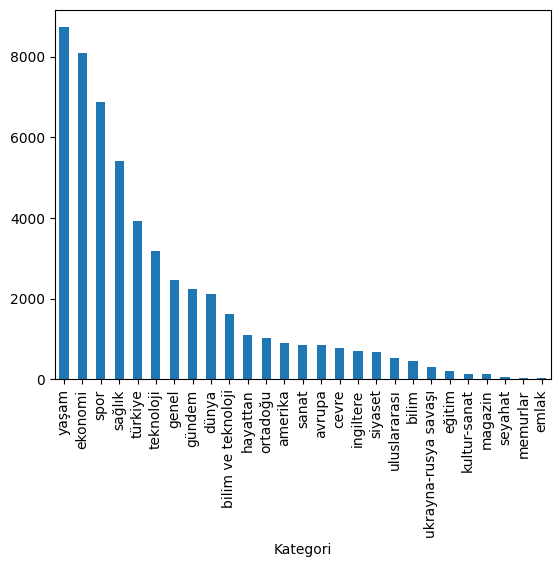

In [13]:
import seaborn as sns
(value_counts.plot(kind='bar'));


Imbalanced datasets are a common problem in machine learning, where one class has significantly more observations than the other. This can lead to biased models and poor performance on the minority class. Several solutions have been proposed to address this issue :    
* 1 - **Undersampling**:  
** Undersampling is a technique used to reduce an imbalanced dataset by decreasing the size of the majority class while preserving all the data from the minority class. This is one of the techniques that data scientists can use to extract more accurate information from an initially imbalanced dataset. However, it has some disadvantages, such as the loss of important information. Despite this, it remains a common and important skill for data scientists.
* 2 - **Oversampling**:  
** This is used when data scientists do not have sufficient information. One class is abundant (majority), while the other is rare or scarce (minority). In oversampling, the scientist increases the number of rare events. The scientist uses a specific technique to create artificial events. One of the techniques used to create artificial events is called Synthetic Minority Over-sampling Technique (SMOTE).
* 3 - **ensemble methods for imbalanced data**
* 4 - **focal loss**  
The method we will use is **Undersampling**

##Undersampling

In [14]:
#First, we take the classes with the most examples, which are 'yaşam', 'ekonomi', 'spor', 'sağlık
selected_categories = ['yaşam', 'ekonomi', 'spor', 'sağlık']
selected_rows = df.loc[df['Kategori'].isin(selected_categories)]
new_df = selected_rows[['Id','cleaned_title', 'Kategori']].copy()

In [15]:
new_df

,Id,cleaned_title,Kategori
459,1380,büyük şirket iflaslarını yöneten uzmandan ftx ...,ekonomi
460,1382,i̇ngilterede yaşam standartları 1950ler sonras...,ekonomi
461,1384,fitch türkiye bankacılık sektörünü uyardı,ekonomi
462,1387,i̇﻿ngilterede yıllık enflasyon 41 yılın yüksek...,ekonomi
463,1388,a﻿bdde yeni tip 1 diyabet ilacına onay tedavid...,sağlık
...,...,...,...
53450,80212,rizede lise öğrencisinden haber alınamıyor,yaşam
53453,80215,barışma maçı,spor
53454,80217,bilgisayar oyunları gençleri gerçek hayattan k...,yaşam
53457,80220,hikmet karaman rakibimizi tebrik ediyoruz,spor


In [16]:
new_df.reset_index(drop=True, inplace=True) #Reordering the index

In [17]:
new_df

,Id,cleaned_title,Kategori
0,1380,büyük şirket iflaslarını yöneten uzmandan ftx ...,ekonomi
1,1382,i̇ngilterede yaşam standartları 1950ler sonras...,ekonomi
2,1384,fitch türkiye bankacılık sektörünü uyardı,ekonomi
3,1387,i̇﻿ngilterede yıllık enflasyon 41 yılın yüksek...,ekonomi
4,1388,a﻿bdde yeni tip 1 diyabet ilacına onay tedavid...,sağlık
...,...,...,...
29091,80212,rizede lise öğrencisinden haber alınamıyor,yaşam
29092,80215,barışma maçı,spor
29093,80217,bilgisayar oyunları gençleri gerçek hayattan k...,yaşam
29094,80220,hikmet karaman rakibimizi tebrik ediyoruz,spor


In [18]:
y = new_df["Kategori"]

<Axes: ylabel='count'>

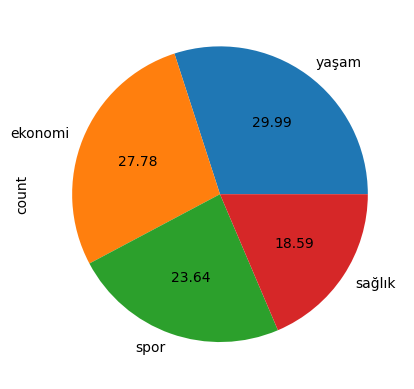

In [19]:
y = new_df["Kategori"]
y.value_counts().plot.pie(autopct='%.2f')


In [20]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
undersample = RandomUnderSampler(random_state=42)
X = new_df["cleaned_title"].to_numpy().reshape(-1, 1) # We convert it to an array and also change its shape
Y = new_df["Kategori"]

In [21]:
 X_under, Y_under = undersample.fit_resample(X, Y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [22]:
print(sorted(Counter(Y_under).items()))

[('ekonomi', 5409), ('sağlık', 5409), ('spor', 5409), ('yaşam', 5409)]


In [23]:
# Creating a new DataFrame after performing undersampling
import pandas as pd
df_under = pd.DataFrame({
    "Baslik": X_under.flatten(),
    "Kategori": Y_under
})

In [24]:
df_under

,Baslik,Kategori
0,ak partiden asgari ücret zammı eyt açıklaması ...,ekonomi
1,kişisel verileri koruma kurumu başkanı bilir i...,ekonomi
2,aralık ayı sanayi üretim rakamları açıklandı,ekonomi
3,2018 yılı yep hedefleri tutturulamadı,ekonomi
4,vekil imam,ekonomi
...,...,...
21631,hacıbey çayına düşen piyade asteğmen abdullah ...,yaşam
21632,i̇stanbulda pazar günü kapalı olacak yollar aç...,yaşam
21633,i̇stanbul arnavutköyde feci kaza ölü yaralılar,yaşam
21634,sara sampaio sarışın,yaşam


In [25]:
y = df_under["Kategori"]

<Axes: ylabel='count'>

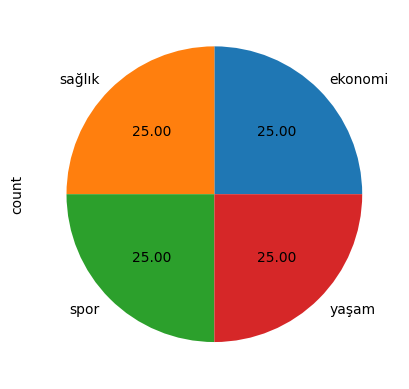

In [26]:
y.value_counts().plot.pie(autopct='%.2f')


In [27]:
"""
Here we are testing, i.e., checking whether our text and label sequences were disrupted after performing undersampling.
"""
print(X_under[1])
print(Y_under[1])

['kişisel verileri koruma kurumu başkanı bilir i̇şlenen verilerle kişilere bilgilendirme yapılmalı']
ekonomi


In [28]:
search_term = str(X_under[1][0])
result = df_under.loc[df_under["Baslik"] == search_term]
print(result)
# As seen, the order has not been disrupted, the same text corresponds to the same class.

                                              Baslik Kategori
1  kişisel verileri koruma kurumu başkanı bilir i...  ekonomi


# Converting the 'Kategori' column into numbers

In [29]:
df_under['label_num'] = df_under['Kategori'].map({
    'ekonomi' : 0,
    'sağlık': 1,
    'spor': 2,
    'yaşam' : 3

})

In [30]:
search_term = str(X_under[1][0])
result = df_under.loc[df_under["Baslik"] == search_term]
print(result)
# We assigned 0 to 'ekonomi' above, and as we can see, it really has 0 in the 'label_num' column.

                                              Baslik Kategori  label_num
1  kişisel verileri koruma kurumu başkanı bilir i...  ekonomi          0


#Splitting our data into Train, Test, and Validation sets

In [31]:
x = df_under['Baslik']
y = df_under['label_num']

In [32]:
x

,Baslik
0,ak partiden asgari ücret zammı eyt açıklaması ...
1,kişisel verileri koruma kurumu başkanı bilir i...
2,aralık ayı sanayi üretim rakamları açıklandı
3,2018 yılı yep hedefleri tutturulamadı
4,vekil imam
...,...
21631,hacıbey çayına düşen piyade asteğmen abdullah ...
21632,i̇stanbulda pazar günü kapalı olacak yollar aç...
21633,i̇stanbul arnavutköyde feci kaza ölü yaralılar
21634,sara sampaio sarışın


In [33]:
train_text, temp_text, train_labels, temp_labels = train_test_split(x, y,
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=y)
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [34]:
print(train_text.shape)
print(temp_text.shape)
print(train_labels.shape)
print(temp_labels.shape)
print(val_text.shape)
print(test_text.shape)
print(val_labels.shape)
print(test_labels.shape)

(15145,)
(6491,)
(15145,)
(6491,)
(3245,)
(3246,)
(3245,)
(3246,)


#Tokenization and Feature extraction

 Before starting this, we first need to specify the length of the title becausethe output vector from the tokenization step needs to have the same length.
To determine the appropriate length, we need to first visualize the distribution of words in the titles.

Text(0, 0.5, 'Number of texts')

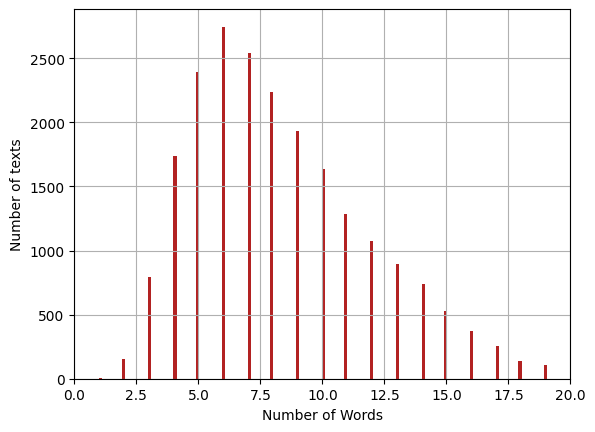

In [35]:
seq_len = [len(title.split()) for title in df_under['Baslik']]
plt.xlim(0, 20)

pd.Series(seq_len).hist(bins = 200,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

Based on this, the average length is around 15, so we will set the length to 15.

In [36]:
MAX_LENGHT = 15
# We are performing the tokenization and encoding process for the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(), #convert the train_text data to a list because the tokenizer expects a list.ز
    max_length = MAX_LENGHT, #pecify the length.
    pad_to_max_length=True, #If the length is less than 15, it will be padded with zeros.
    truncation=True,#If the length is greater than 15, it will be truncated.
    return_tensors='pt'
     #return the result as PyTorch tensors, as official models have weights compatible with PyTorch-Transformers.
     )
#perform the tokenization and encoding process for the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt'
)
# perform the tokenization and encoding process for the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt'
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
train_y = torch.tensor(train_labels.tolist())
val_y = torch.tensor(val_labels.tolist())
test_y = torch.tensor(test_labels.tolist())

In [38]:
# Defining the Data Loader structure
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_data = TensorDataset(tokens_train['input_ids'], tokens_train['attention_mask'], train_y)
train_sampler = RandomSampler(train_data)                     # It is used to randomly select samples from the training dataset.
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(tokens_val['input_ids'], tokens_val['attention_mask'], val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

#Model Building Process

##Freezing the model parameters

In [39]:
for param in bert.parameters():
    param.requires_grad = False
# We are freezing the weights of the BERT model here. This will prevent these weights from being updated during the training process.
# The reason is that when using a pre-trained model like BERT for a new task, in this case, multi-class news classification,
# we should freeze most of the weights and only update the weights in the last layers.
# This helps prevent the model from losing the knowledge it has acquired previously and allows us to achieve good results.
# Additionally, it reduces training time, memory usage, and computer resource consumption, as well as mitigating the risk of overfitting.

##Our model

In [40]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,4)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
      a = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(a)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x


model = BERT_Arch(bert)
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)

cross_entropy  = nn.NLLLoss()
epochs = 8
# Here, we have chosen to use the ReLU activation function in the hidden layers because it performs better and provides excellent results compared to other activation functions.
# In the output layer, we use Softmax because our output has more than two classes, and for multi-class classification tasks, we need to use an activation function like Softmax.
# we didn't used The Sigmoid function because it can only be used for binary classification.
# AdamW is considered a reliable and preferred choice by many developers due to its effectiveness.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Defining the Train and Evaluate Methods

In [41]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)

  return avg_loss

def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:


      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

#Model Results

In [42]:

weights_path = '/content/drive/MyDrive/NewsClassification/outputBert.pt'

# Train and predict
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), weights_path)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 8
  Batch    50  of    474.
  Batch   100  of    474.
  Batch   150  of    474.
  Batch   200  of    474.
  Batch   250  of    474.
  Batch   300  of    474.
  Batch   350  of    474.
  Batch   400  of    474.
  Batch   450  of    474.

Evaluating...
  Batch    50  of    102.
  Batch   100  of    102.

Training Loss: 1.256
Validation Loss: 1.093

 Epoch 2 / 8
  Batch    50  of    474.
  Batch   100  of    474.
  Batch   150  of    474.
  Batch   200  of    474.
  Batch   250  of    474.
  Batch   300  of    474.
  Batch   350  of    474.
  Batch   400  of    474.
  Batch   450  of    474.

Evaluating...
  Batch    50  of    102.
  Batch   100  of    102.

Training Loss: 1.012
Validation Loss: 0.842

 Epoch 3 / 8
  Batch    50  of    474.
  Batch   100  of    474.
  Batch   150  of    474.
  Batch   200  of    474.
  Batch   250  of    474.
  Batch   300  of    474.
  Batch   350  of    474.
  Batch   400  of    474.
  Batch   450  of    474.

Evaluating...
  Batch    50  of

#Model Performance

In [43]:
path = '/content/drive/MyDrive/NewsClassification/outputBert.pt'
model.load_state_dict(torch.load(path))

<ipython-input-43-82ed2f5f2005>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [44]:
with torch.no_grad():
  preds = model(tokens_test['input_ids'], tokens_test['attention_mask'])
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       812
           1       0.90      0.86      0.88       811
           2       0.96      0.93      0.95       811
           3       0.86      0.86      0.86       812

    accuracy                           0.89      3246
   macro avg       0.89      0.89      0.89      3246
weighted avg       0.89      0.89      0.89      3246



In [45]:
precision = [0.83, 0.90, 0.97, 0.88]
recall = [0.92, 0.86, 0.95, 0.86]
f1_score = [0.87, 0.88, 0.95, 0.87]
labels = ['ekonomi 0', 'sağlık 1', 'spor 2', 'yaşam 3']

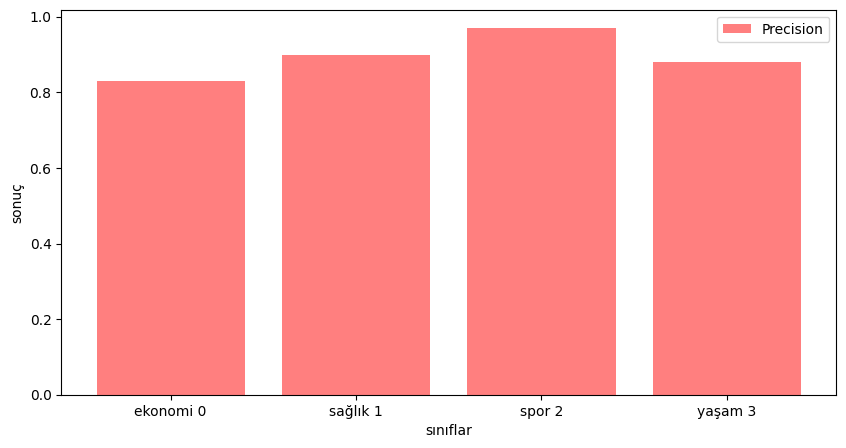

In [46]:
  #Precision
  plt.figure(figsize=(10, 5))
  plt.bar(labels, precision, color='red', alpha=0.5, label='Precision')
  plt.xlabel('sınıflar')
  plt.ylabel('sonuç')
  plt.legend()
  plt.show()

Ekonomi 0:  
Precision (0.83): This means that the model correctly predicted that 83% of the instances belong to the Ekonomi  (0) category, and these instances indeed belong to that class. The remaining 17% represents instances where the model predicted them as Ekonomi  (0), but they actually did not belong to that class.  

Sağlık 1:  
Precision (0.90): This means that the model correctly predicted that 90% of the instances belong to the Sağlık  (1) category, and these instances indeed belong to that class. The remaining 10% represents instances where the model predicted them as Sağlık  (1), but they actually did not belong to that class.    

Spor 2:  
Precision (0.97): This means that the model correctly predicted that 97% of the instances belong to the Spor (2) category, and these instances indeed belong to that class. The remaining 3% represents instances where the model predicted them as Spor (2), but they actually did not belong to that class.  

Yaşam 3:    
Precision (0.88): This means that the model correctly predicted that 88% of the instances belong to the Yaşam (3) category, and these instances indeed belong to that class. The remaining 13% represents instances where the model predicted them as Yaşam (3), but they actually did not belong to that class.   

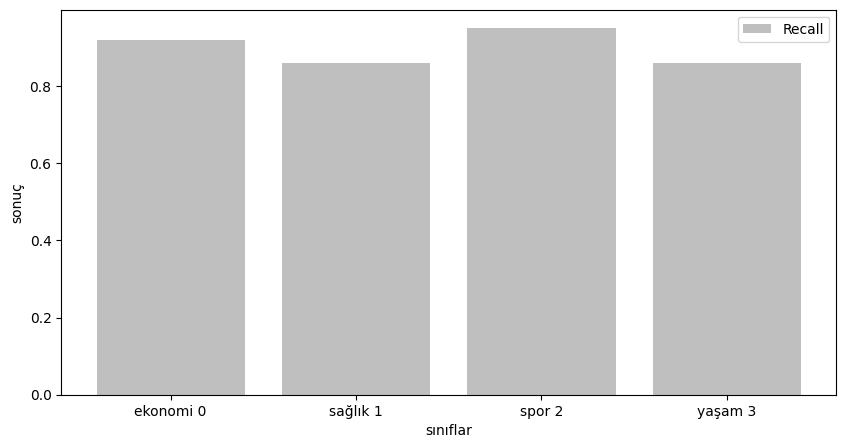

In [47]:
#Precision
plt.figure(figsize=(10, 5))
plt.bar(labels, recall, color='gray', alpha=0.5, label='Recall')
plt.xlabel('sınıflar')
plt.ylabel('sonuç')
plt.legend()
plt.show()

Ekonomi 0:  
Recall (0.92): This means that the model correctly classified 92% of the instances that actually belong to the Ekonomi (0) category. However, there were still 8% of the instances that the model failed to classify correctly.  

Sağlık 1:   
Recall (0.86): This means that the model correctly classified 86% of the instances that actually belong to the Sağlık (1) category. The remaining 14% were instances that the model failed to classify correctly.     

Spor 2:   
Recall (0.94): This means that the model correctly classified 94% of the instances that actually belong to the Spor (2) category. However, 6% of the instances were misclassified by the model.  

Yaşam 3:  
Recall (0.86): This means that the model correctly classified 86% of the instances that actually belong to the Yaşam (3) category. The remaining 14% were instances that the model failed to classify correctly.   

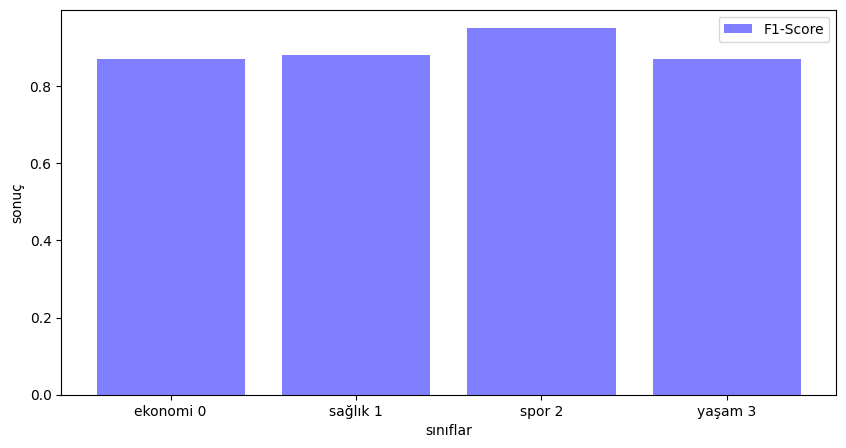

In [48]:
#f1-score
plt.figure(figsize=(10, 5))
plt.bar(labels, f1_score, color='blue', alpha=0.5, label='F1-Score')
plt.xlabel('sınıflar')
plt.ylabel('sonuç')
plt.legend()
plt.show()

Ekonomi 0:  
F1-Score (0.87): This ratio provides a balance between precision and recall and gives a comprehensive view of the model's performance in classifying Ekonomi (0). A high F1-score (0.87) indicates that the model has achieved a good balance between precision and recall, reflecting the model’s effectiveness in classifying Ekonomi (0).

Sağlık 1:   
F1-Score (0.88): This ratio provides a balance between precision and recall and gives a comprehensive view of the model's performance in classifying Sağlık (1). A high F1-score (0.88) indicates that the model has achieved a good balance between precision and recall, reflecting the model’s effectiveness in classifying Sağlık (1).

Spor 2:   
F1-Score (0.95): This ratio provides a balance between precision and recall and gives a comprehensive view of the model's performance in classifying Spor (2). A high F1-score (0.95) indicates that the model has achieved a good balance between precision and recall, reflecting the model’s effectiveness in classifying Spor (2).

Yaşam 3:      
F1-Score (0.87): This ratio provides a balance between precision and recall and gives a comprehensive view of the model's performance in classifying Yaşam (3). A high F1-score (0.87) indicates that the model has achieved a good balance between precision and recall, reflecting the model’s effectiveness in classifying Yaşam (3).  

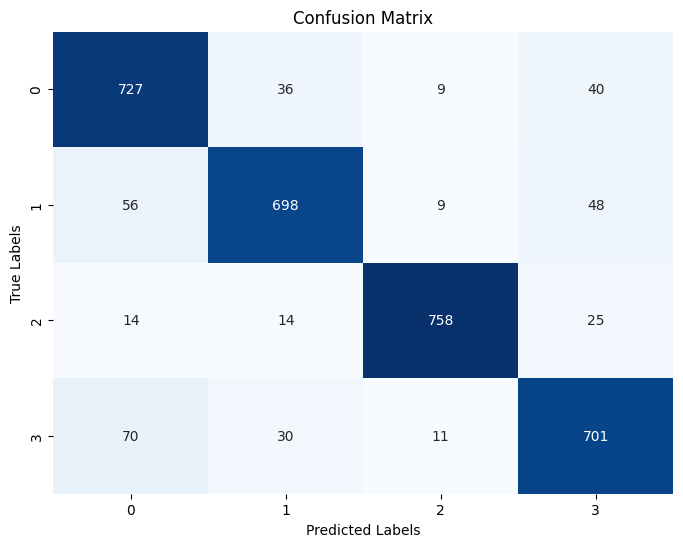

In [49]:
cm = confusion_matrix(test_y, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The model correctly classified 746 instances as Ekonomi (0).  
The model correctly classified 687 instances as Sağlık (1).   
The model correctly classified 765 instances as Spor (2).   
The model correctly classified 697 instances as Yaşam (3).   
These values represent the True Positive values in the confusion matrix.   

Based on these results, it can be seen that the model performs well in classification overall. This is supported by the high values in precision, recall, and F1-scores across all classes (0 to 3). For example, precision ranges from 0.83 to 0.97, recall ranges from 0.86 to 0.94, and the F1-score ranges from 0.87 to 0.95. These results positively indicate that the model has a strong classification capability.

#Test

In [50]:
file_path = "/content/drive/MyDrive/NewsClassification/stop.tr.turkish-lucene.txt"
with open(file_path, "r", encoding="utf-8") as file:
    stop_words = file.read().splitlines()
def clean(df):
    punctuation_no_space = re.compile(r"(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})|(‘)|(“)|(”)|(°)|(\')")
    punctuation_with_space = re.compile(r"(<br\s/><br\s/?)|(-)|(/)|(:)")
    html_tags = r'<.*?>'
    cleaned_lines = []
    for line in df:
        line_cleaned = punctuation_no_space.sub("", line.lower())
        line_cleaned = punctuation_with_space.sub(" ", line_cleaned)
        line_cleaned = re.sub(html_tags, "", line_cleaned)
        line_cleaned = line_cleaned.split()
        line_cleaned = [word for word in line_cleaned if word not in stop_words]
        cleaned_lines.append(' '.join(line_cleaned))

    return cleaned_lines


  
    'ekonomi' : 0,  
    'sağlık': 1,  
    'spor': 2,  
    'yaşam' : 3  
  
  

In [51]:
testText = ["Sinop'ta soğuk hava depolarından çıkarılan toriklerden lakerda yapımına başlandı", #yaşam (3)
                    "KDV istismarını önleyecek düzenleme haksız rekabetin önüne geçecek",#ekonomi (0)
                    "Ünlü teknik direktör, şampiyon yaptığı takıma başkan oldu",#sport (2)
                    "Türk doktorun “Fındık tekniği” yöntemi dünya tıp literatürüne girdi",#sağlık (1)
                    ]
testText = clean(testText)


In [52]:
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    testText,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt'
)

with torch.no_grad():
  preds = model(tokens_unseen['input_ids'],tokens_unseen['attention_mask'])
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


array([3, 0, 2, 1])